In [ ]:
!pip install opencv-python pywavelets

In [1]:
import cv2
import pywt
import numpy as np

def blur_detect(img, threshold):
    # Check if the image has an alpha channel (RGBA format)
    if img.shape[2] == 4:
        # Convert the image to RGB by ignoring the alpha channel
        img = img[:, :, :3]

    # Convert image to grayscale
    Y = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    M, N = Y.shape

    # Crop input image to be divisible by 16
    Y = Y[0:int(M / 16) * 16, 0:int(N / 16) * 16]

    # Step 1: compute Haar wavelet of input image
    LL1, (LH1, HL1, HH1) = pywt.dwt2(Y, 'haar')
    LL2, (LH2, HL2, HH2) = pywt.dwt2(LL1, 'haar')
    LL3, (LH3, HL3, HH3) = pywt.dwt2(LL2, 'haar')

    # Construct the edge map in each scale (Step 2)
    E1 = np.sqrt(np.power(LH1, 2) + np.power(HL1, 2) + np.power(HH1, 2))
    E2 = np.sqrt(np.power(LH2, 2) + np.power(HL2, 2) + np.power(HH2, 2))
    E3 = np.sqrt(np.power(LH3, 2) + np.power(HL3, 2) + np.power(HH3, 2))

    M1, N1 = E1.shape

    # Sliding window sizes for each level
    sizeM1, sizeN1 = 8, 8
    sizeM2, sizeN2 = int(sizeM1 / 2), int(sizeN1 / 2)
    sizeM3, sizeN3 = int(sizeM2 / 2), int(sizeN2 / 2)

    N_iter = int((M1 / sizeM1) * (N1 / sizeN1))

    Emax1 = np.zeros((N_iter))
    Emax2 = np.zeros((N_iter))
    Emax3 = np.zeros((N_iter))

    count = 0
    x1, y1 = 0, 0
    x2, y2 = 0, 0
    x3, y3 = 0, 0
    Y_limit = N1 - sizeN1

    while count < N_iter:
        # Get the maximum value of sliding windows over edge maps in each level
        Emax1[count] = np.max(E1[x1:x1 + sizeM1, y1:y1 + sizeN1])
        Emax2[count] = np.max(E2[x2:x2 + sizeM2, y2:y2 + sizeN2])
        Emax3[count] = np.max(E3[x3:x3 + sizeM3, y3:y3 + sizeN3])

        if y1 == Y_limit:
            x1 += sizeM1
            y1 = 0
            x2 += sizeM2
            y2 = 0
            x3 += sizeM3
            y3 = 0
            count += 1
        else:
            y1 += sizeN1
            y2 += sizeN2
            y3 += sizeN3
            count += 1

    # Step 3: Edge detection
    EdgePoint1 = Emax1 > threshold
    EdgePoint2 = Emax2 > threshold
    EdgePoint3 = Emax3 > threshold
    EdgePoint = EdgePoint1 + EdgePoint2 + EdgePoint3

    n_edges = EdgePoint.shape[0]

    # Rule 2: Dirac-Structure or Astep-Structure
    DAstructure = (Emax1[EdgePoint] > Emax2[EdgePoint]) * (Emax2[EdgePoint] > Emax3[EdgePoint])

    # Rule 3: Roof-Structure or Gstep-Structure
    RGstructure = np.zeros((n_edges))
    for i in range(n_edges):
        if EdgePoint[i] == 1:
            if Emax1[i] < Emax2[i] and Emax2[i] < Emax3[i]:
                RGstructure[i] = 1

    # Rule 4: Roof-Structure
    RSstructure = np.zeros((n_edges))
    for i in range(n_edges):
        if EdgePoint[i] == 1:
            if Emax2[i] > Emax1[i] and Emax2[i] > Emax3[i]:
                RSstructure[i] = 1

    # Rule 5: Edge more likely to be in a blurred image
    BlurC = np.zeros((n_edges))
    for i in range(n_edges):
        if RGstructure[i] == 1 or RSstructure[i] == 1:
            if Emax1[i] < threshold:
                BlurC[i] = 1

    # Step 6: Calculate blur extent
    Per = np.sum(DAstructure) / np.sum(EdgePoint)

    # Step 7: Blur extent calculation
    if (np.sum(RGstructure) + np.sum(RSstructure)) == 0:
        BlurExtent = 100
    else:
        BlurExtent = np.sum(BlurC) / (np.sum(RGstructure) + np.sum(RSstructure))

    return Per, BlurExtent

# Read image using OpenCV
image_path = r"sample_images\tilt_head_left.jpg"  # Replace with your image file path
img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

# Check if the image was loaded successfully
if img is None:
    print("Error: Could not load image.")
else:
    # Set a threshold value for blur detection
    threshold = 35  # You can adjust this value as needed

    # Detect blur in the image
    per, blurext = blur_detect(img, threshold)

    # Display the results
    print(f"Percentage of Dirac/Astep structures (Per): {per * 100:.2f}%")
    print(f"Blur extent (BlurExtent): {blurext * 100:.2f}%")

    classification = False

    if blurext > 0.5:
        classification = True
    print(" Per: {0:.5f}, blur extent: {1:.4f}, is blur: {2}".format(per, blurext, classification))


Percentage of Dirac/Astep structures (Per): 0.00%
Blur extent (BlurExtent): 99.68%
 Per: 0.00000, blur extent: 0.9968, is blur: True


In [ ]:
import cv2
import pywt
import numpy as np

def blur_detect(img, threshold):
    # Check if the image has an alpha channel (RGBA format)
    if img.shape[2] == 4:
        # Convert the image to RGB by ignoring the alpha channel
        img = img[:, :, :3]

    # Convert image to grayscale
    Y = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    M, N = Y.shape

    # Crop input image to be divisible by 16
    Y = Y[0:int(M / 16) * 16, 0:int(N / 16) * 16]

    # Step 1: compute Haar wavelet of input image
    LL1, (LH1, HL1, HH1) = pywt.dwt2(Y, 'haar')
    LL2, (LH2, HL2, HH2) = pywt.dwt2(LL1, 'haar')
    LL3, (LH3, HL3, HH3) = pywt.dwt2(LL2, 'haar')

    # Construct the edge map in each scale (Step 2)
    E1 = np.sqrt(np.power(LH1, 2) + np.power(HL1, 2) + np.power(HH1, 2))
    E2 = np.sqrt(np.power(LH2, 2) + np.power(HL2, 2) + np.power(HH2, 2))
    E3 = np.sqrt(np.power(LH3, 2) + np.power(HL3, 2) + np.power(HH3, 2))

    M1, N1 = E1.shape

    # Sliding window sizes for each level
    sizeM1, sizeN1 = 8, 8
    sizeM2, sizeN2 = int(sizeM1 / 2), int(sizeN1 / 2)
    sizeM3, sizeN3 = int(sizeM2 / 2), int(sizeN2 / 2)

    N_iter = int((M1 / sizeM1) * (N1 / sizeN1))

    Emax1 = np.zeros((N_iter))
    Emax2 = np.zeros((N_iter))
    Emax3 = np.zeros((N_iter))

    count = 0
    x1, y1 = 0, 0
    x2, y2 = 0, 0
    x3, y3 = 0, 0
    Y_limit = N1 - sizeN1

    while count < N_iter:
        # Get the maximum value of sliding windows over edge maps in each level
        Emax1[count] = np.max(E1[x1:x1 + sizeM1, y1:y1 + sizeN1])
        Emax2[count] = np.max(E2[x2:x2 + sizeM2, y2:y2 + sizeN2])
        Emax3[count] = np.max(E3[x3:x3 + sizeM3, y3:y3 + sizeN3])

        if y1 == Y_limit:
            x1 += sizeM1
            y1 = 0
            x2 += sizeM2
            y2 = 0
            x3 += sizeM3
            y3 = 0
            count += 1
        else:
            y1 += sizeN1
            y2 += sizeN2
            y3 += sizeN3
            count += 1

    # Step 3: Edge detection
    EdgePoint1 = Emax1 > threshold
    EdgePoint2 = Emax2 > threshold
    EdgePoint3 = Emax3 > threshold
    EdgePoint = EdgePoint1 + EdgePoint2 + EdgePoint3

    n_edges = EdgePoint.shape[0]

    # Rule 2: Dirac-Structure or Astep-Structure
    DAstructure = (Emax1[EdgePoint] > Emax2[EdgePoint]) * (Emax2[EdgePoint] > Emax3[EdgePoint])

    # Rule 3: Roof-Structure or Gstep-Structure
    RGstructure = np.zeros((n_edges))
    for i in range(n_edges):
        if EdgePoint[i] == 1:
            if Emax1[i] < Emax2[i] and Emax2[i] < Emax3[i]:
                RGstructure[i] = 1

    # Rule 4: Roof-Structure
    RSstructure = np.zeros((n_edges))
    for i in range(n_edges):
        if EdgePoint[i] == 1:
            if Emax2[i] > Emax1[i] and Emax2[i] > Emax3[i]:
                RSstructure[i] = 1

    # Rule 5: Edge more likely to be in a blurred image
    BlurC = np.zeros((n_edges))
    for i in range(n_edges):
        if RGstructure[i] == 1 or RSstructure[i] == 1:
            if Emax1[i] < threshold:
                BlurC[i] = 1

    # Step 6: Calculate blur extent
    Per = np.sum(DAstructure) / np.sum(EdgePoint)

    # Step 7: Blur extent calculation
    if (np.sum(RGstructure) + np.sum(RSstructure)) == 0:
        BlurExtent = 100
    else:
        BlurExtent = np.sum(BlurC) / (np.sum(RGstructure) + np.sum(RSstructure))

    return Per, BlurExtent

Blur Detected on frame: 9, BlurExtent : 1.00
Blur Detected on frame: 12, BlurExtent : 1.00
Blur Detected on frame: 18, BlurExtent : 0.99
Blur Detected on frame: 22, BlurExtent : 0.99
Blur Detected on frame: 56, BlurExtent : 0.99
Blur Detected on frame: 69, BlurExtent : 0.99
Blur Detected on frame: 72, BlurExtent : 0.99
Blur Detected on frame: 74, BlurExtent : 0.99
Blur Detected on frame: 84, BlurExtent : 0.99
Blur Detected on frame: 88, BlurExtent : 0.99
Blur Detected on frame: 90, BlurExtent : 0.99
Blur Detected on frame: 93, BlurExtent : 0.99
Blur Detected on frame: 96, BlurExtent : 0.99
Blur Detected on frame: 102, BlurExtent : 1.00
Blur Detected on frame: 104, BlurExtent : 0.99
Blur Detected on frame: 105, BlurExtent : 0.99
Blur Detected on frame: 114, BlurExtent : 1.00
Blur Detected on frame: 119, BlurExtent : 0.99
Blur Detected on frame: 129, BlurExtent : 0.99


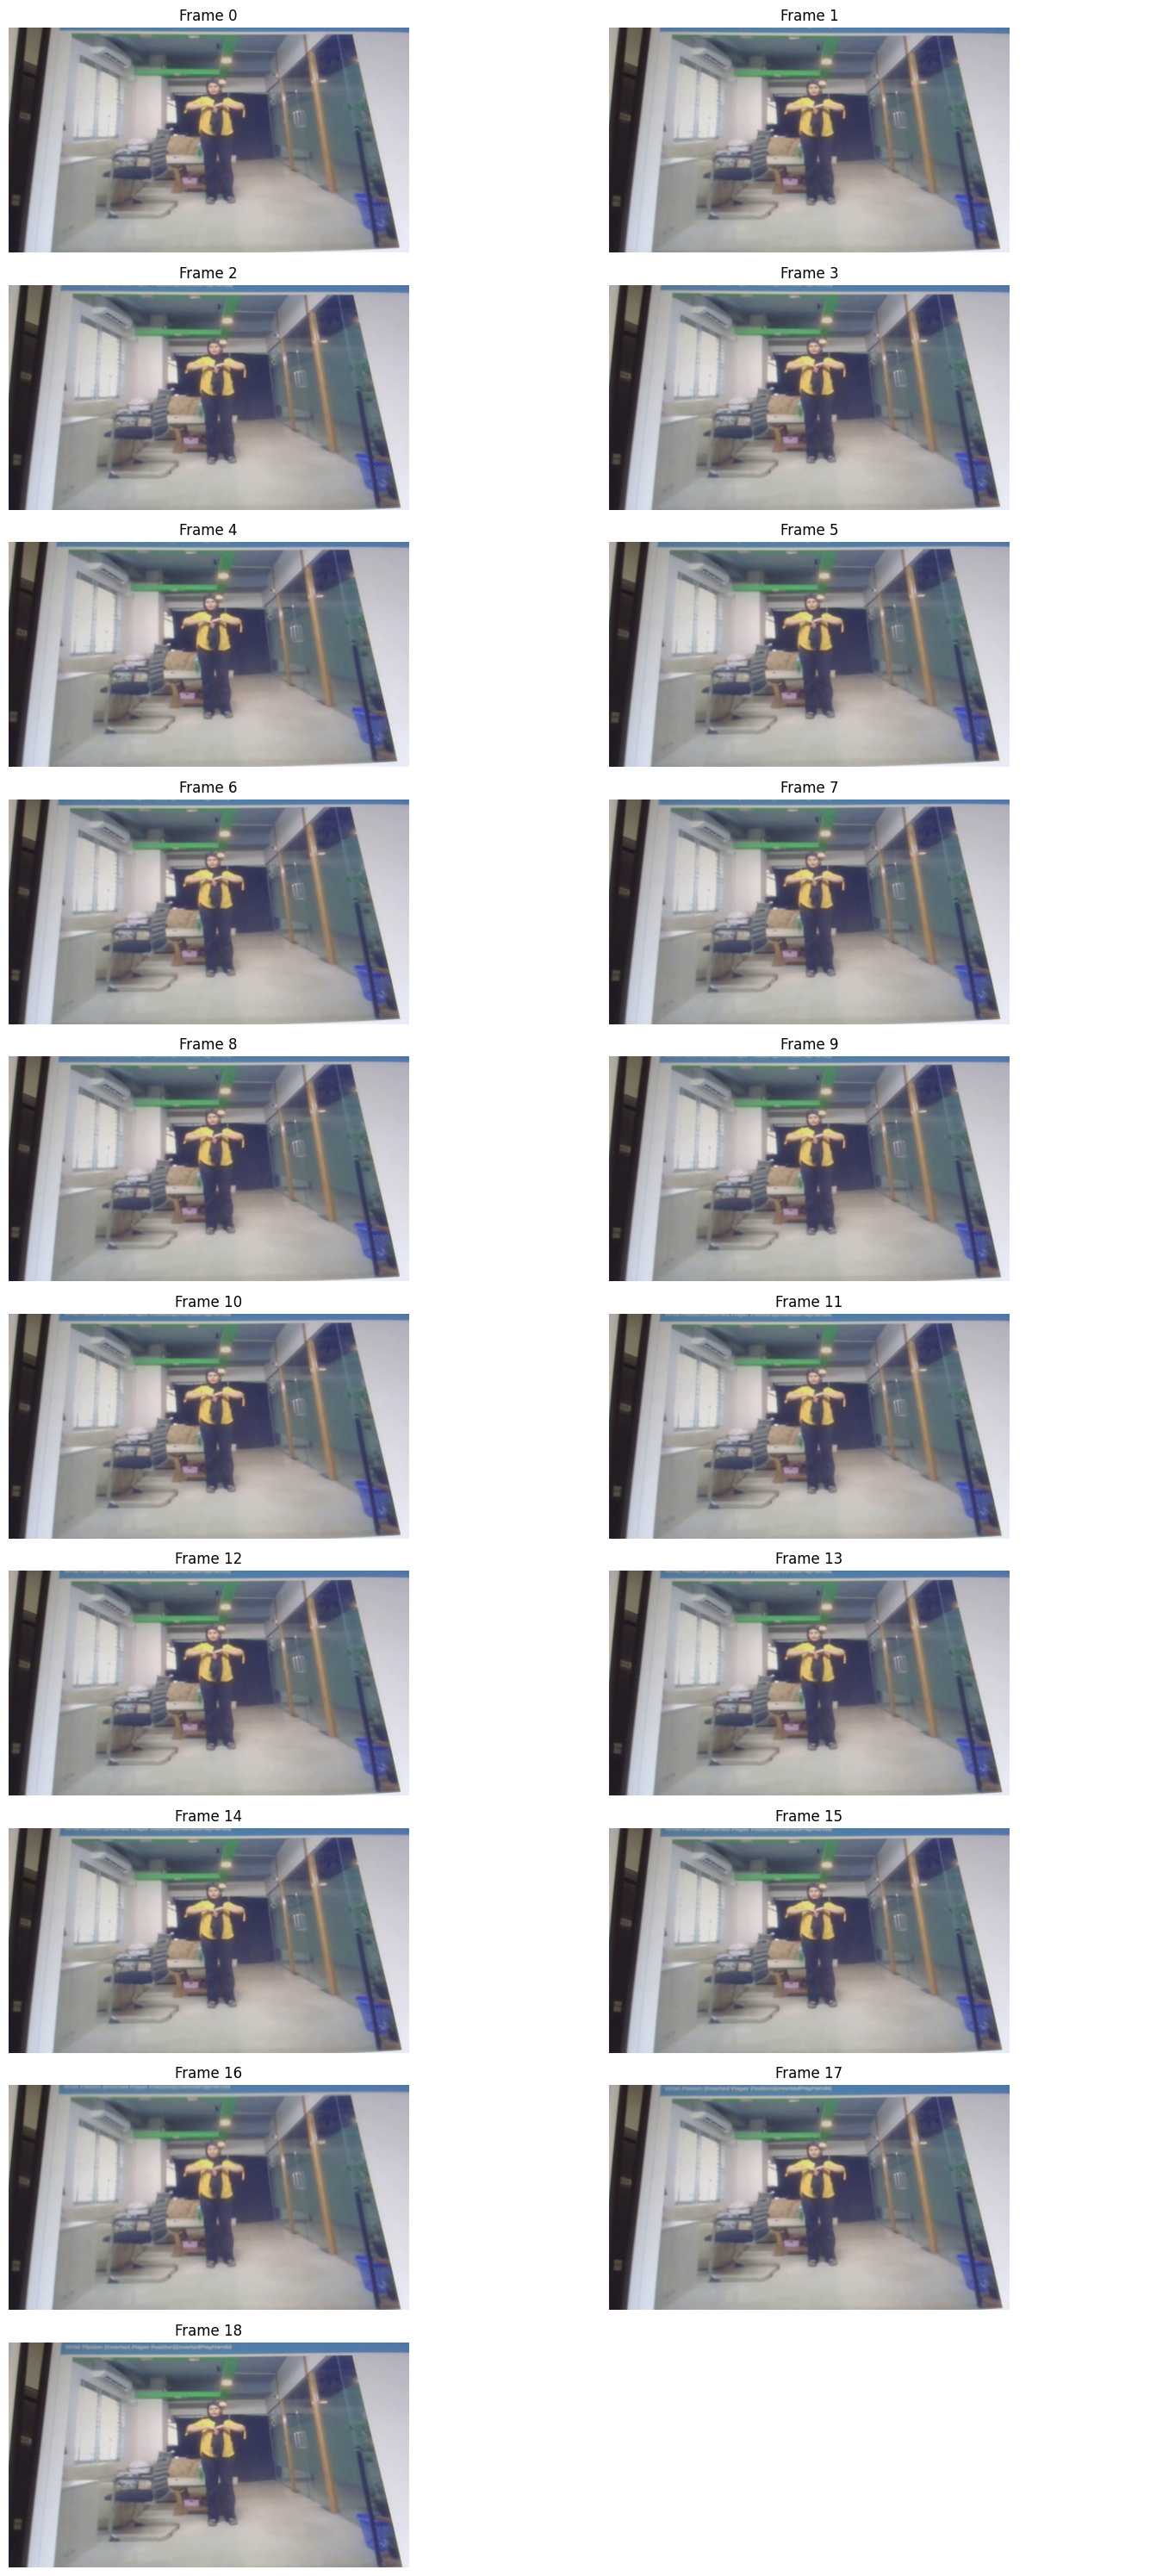

In [11]:
cap = cv2.VideoCapture(r"sample_images\temp.mp4")

if not cap.isOpened():
    print("Error: Could not open video file.")
count = 0
blurry_frames = []
while True:
    # Read each frame from the video
    ret, frame = cap.read()
    if not ret:
        break  # Exit if no more frames are available

    # Detect blur in the current frame

    is_blur, laplacian_var = blur_detect(frame, threshold=50)
    
    if is_blur:
        blurry_frames.append(frame)
        print(f"Blur Detected on frame: {count}, BlurExtent : {laplacian_var:.2f}")

    # Display the frame and blur information
    # text = f'Blur Detected: {"Yes" if is_blur else "No"}, Laplacian Variance: {laplacian_var:.2f}'
    # cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0) if not is_blur else (0, 0, 255), 2)
    # cv2.imshow('Video Frame', frame)

    # Press 'q' to exit the video processing
    # if cv2.waitKey(30) & 0xFF == ord('q'):
    #     break
    count += 1
# Release the video capture and close the display window

cap.release()


import matplotlib.pyplot as plt
import cv2

# Assuming blurry_frames list contains the detected blurry frames
def plot_blurry_frames(frames, frames_per_row=5):
    num_frames = len(frames)
    num_rows = (num_frames + frames_per_row - 1) // frames_per_row  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, frames_per_row, figsize=(15, num_rows * 3))

    # Flatten the axes array for easy indexing
    axes = axes.flatten()

    for idx, (frame, ax) in enumerate(zip(frames, axes)):
        # Convert the frame from BGR to RGB for plotting
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        ax.imshow(frame_rgb)
        ax.axis('off')
        ax.set_title(f'Frame {idx}')

    # Hide any remaining empty subplots
    for ax in axes[num_frames:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Assuming you already have the 'blurry_frames' list from the video processing
plot_blurry_frames(blurry_frames, frames_per_row=2)
